In [11]:
import pandas as pd
import folium
import folium.plugins
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc

# WA Crash Viz and Analysis
### By Katharine Chen, Tianqi Fang, Yutong Liu, Shuyi Yin

## Problem Background

+ Broad variety of factors (environmental, physical, etc) that contribute to a road’s overall safety;<br>
+ Important for general users, in addition to administrative/government officials, to be able to assess road conditions easily in a user-friendly interface;

## Use case

+ Average driver may consult the map and analysis before travel;<br>
+ DOT planners, police officers and other professionals may look deeper into contributing factors;<br>
+ They are all **non-programmers** and thus need an interactive environment that visualize past accidents and tell them what factors contribute most to crashes;<br>
+ ***Rainy day, steep downhill curved road, old car, little traffic, young driver;***

## Python Libraries:
+ Folium;
+ Bokeh;

## Data cleaning

In [ ]:
def clean(source, sink):
    df = pd.read_csv(source)
    df = df.dropna()
    df.to_csv(sink)
    pass

In [ ]:
# use case:
clean("coords.csv", "coords_cleaned.csv")

### Load and wrangle dataset with Pandas

In [2]:
def readCleanLoc(source):
    '''
    @param source: cleaned csv file of lat/lons
    @use case: df_cleaned = readLoc("coords_gps.csv")
    '''
    # read from file
    df_cleaned = pd.read_csv(source)
    
    # change column name
    df_cleaned.columns = ['lat', 'lon']
    
    # assert no nan after cleaning
    assert not df_cleaned.isnull().values.any()
    return df_cleaned

In [3]:
def readOrig(origSource, cleanLocSource):
    '''
    @param origSource: original dataset file
    @param cleanLocSource: cleaned lat/lon file
    @use case: df = readOrig("WA_Rural_St_RtesCrashes_Full.csv")
    '''

    # read
    df = pd.read_csv(origSource)
    
    # select columns
    columns = ['DATE',
               'PRIMARY TRAFFICWAY',
               'MILEPOST',
               '# INJ',
               '# FAT',
               'WA STATE PLANE SOUTH - X 2010 - FORWARD',
               'WA STATE PLANE SOUTH - Y 2010 - FORWARD']
    df = df[columns]
    
    # drop rows that have nan in defined columns
    df = df.dropna(subset=['WA STATE PLANE SOUTH - X 2010 - FORWARD',
                      'WA STATE PLANE SOUTH - Y 2010 - FORWARD'])
    
    # must collapse index
    df = df.reset_index(drop=True)
    
    # transform time
    df['date'] = pd.to_datetime(df['DATE'])
    df['year'] = df['date'].dt.year
    
    columns = ['PRIMARY TRAFFICWAY',
               'MILEPOST',
               '# INJ',
               '# FAT',
               'WA STATE PLANE SOUTH - X 2010 - FORWARD',
               'WA STATE PLANE SOUTH - Y 2010 - FORWARD',
               'year']
    df = df[columns]
    
    # change columns name
    df.columns = ['PRIMARY TRAFFICWAY',
                  'MILEPOST',
                  '# INJ',
                  '# FAT',
                  'lat',
                  'lon',
                  'year']
    
    # update lat lon
    df_cleaned = readCleanLoc(cleanLocSource)
    df.lat = df_cleaned.lat
    df.lon = df_cleaned.lon
    
    # assert no nan
    assert not df.isnull().values.any()
    assert not df_cleaned.isnull().values.any()

    return df

## Folium simple example

In [25]:
def plotFolium(origFile, cleanLoc, mapSink, start, end):
    '''
    @param origFile: original dataset file
    @param cleanLoc: cleaned lat/lon file
    @param mapSink: saving destination of generated map
    '''

    # read data
    df = readOrig(origFile, cleanLoc)
    
    # create map object
    accWA = folium.Map([df.lat.median(), df.lon.median()],
                   # tiles="cartodbpositron",
                   tiles = '',
                   # width='80%',
                   # height='80%',
                   prefer_canvas=True,
                   zoom_start=8)
    # add tile layer
    folium.TileLayer('cartodbpositron', name = 'bright').add_to(accWA)
    folium.TileLayer('CartoDB dark_matter', name = 'dark').add_to(accWA)
    
    # create crash layer
    crashes = []
    clusters = []
    for year in range(start, end + 1):
        
        # create cluster layer
        yrClust = folium.FeatureGroup(name=str(year) + '_Clusters', show=False)
        clusters.append(yrClust)
        accWA.add_child(clusters[-1])

        # add cluster layer to feature group
        marClst = folium.plugins.FastMarkerCluster(
            data=list(zip(df[df['year'] == year]['lat'].values, df[df['year'] == year]['lon'].values))
        ).add_to(clusters[-1])
        
        # individual crashes
        yrCrash = folium.FeatureGroup(name=str(year) + '_Crashes', show=False)
        crashes.append(yrCrash)
        accWA.add_child(crashes[-1])
        
        # add crashe events to their layers
        for _, row in df[df['year'] == year].iterrows():
            
            # define circle color
            if row['# INJ'] > 0:
                cirlColor = "#007849" 
            elif row['# FAT'] > 0: 
                cirlColor = 'red'
            else:
                cirlColor = 'steelblue'
            
            # define circle radius
            if row['# INJ'] + row['# FAT'] > 0:
                cirlRadius = max(row['# INJ'], row['# FAT']) * 3
            else:
                cirlRadius = 1
            
            folium.CircleMarker([row['lat'], row['lon']],
                                radius=cirlRadius,
                                popup=folium.Popup("INJ: {}, FAT: {}".format(
                                row['# INJ'], row['# FAT']), max_width=150),
                                # fill_color="#3db7e4",
                                # color=cirlColor,
                                weight = 0.2,
                                fill_color=cirlColor,
                                fill=True,
                                fill_opacity=0.4
                         ).add_to(crashes[-1])
    
        

    # add layer control
    folium.LayerControl().add_to(accWA)
            
    # save map
    accWA.save(mapSink)
    
    return accWA

Do not excecute the following cell

In [ ]:
# add layers of crashes by year
for year in ...:
    yrCrash = folium.FeatureGroup(name=str(year) + '_Crashes', show=False)
    crashes.append(yrCrash)
    accWA.add_child(crashes[-1])

In [ ]:
# plot the individual events
for year in ...:
    
    # iterate in a loop
    for _, row in df[df['year'] == year].iterrows():
        
        ...
        
        folium.CircleMarker([row['lat'], row['lon']],
                            radius=cirlRadius,
                            popup=folium.Popup("INJ: {}, FAT: {}".format(
                            row['# INJ'], row['# FAT']), max_width=150),
                            weight = 0.2,
                            fill_color=cirlColor,
                            fill=True,
                            fill_opacity=0.4
                     ).add_to(crashes[-1])
        # ievents are added to its corresponding layer by Year

In [26]:
_ = plotFolium("WA_Rural_St_RtesCrashes_Full.csv",
            "coords_gps.csv",
            "folium_year.html",
            2014, 2017)

##### View the Crashes By Year plot [here](https://syin3.github.io/WA-Crash-Viz-and-Analysis/folium_year.html);<br>
##### View the Crashes Injuries By County plot [here](https://syin3.github.io/WA-Crash-Viz-and-Analysis/folium_injuries_fats_by_county.html);<br>
##### View the Crashes Fatalities By County plot [here](https://syin3.github.io/WA-Crash-Viz-and-Analysis/folium_fats_by_county2y.html);<br>

## Bokeh simple example

In [8]:
def plotBokeh(origFile, cleanLoc, mapSink, start, end):
    
    # import local modules
    import math
    from bokeh.io import show
    from bokeh.palettes import brewer
    from bokeh.models import ColumnDataSource
    from bokeh.plotting import figure, output_file, save
    from bokeh.tile_providers import get_provider, Vendors
    
    # def coordinate conversion
    def merc(coords):
        lat = coords[0]
        lon = coords[1]

        r_major = 6378137.000
        x = r_major * math.radians(lon)
        scale = x/lon
        y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
            lat * (math.pi/180.0)/2.0)) * scale
        return (x, y)
    
    
    
    # read data
    df = readOrig(origFile, cleanLoc)
    
    for year in range(start, end + 1):
        output_file("bokeh_year_{}.html".format(year))
        tile_provider = get_provider(Vendors.CARTODBPOSITRON)

        cirlColor = []
        cirlRadius = []
        for _, row in df[df['year'] == year].iterrows():
            # define circle color
            if row['# INJ'] > 0:
                cirlColor.append("#007849" )
            elif row['# FAT'] > 0: 
                cirlColor.append('red')
            else:
                cirlColor.append('steelblue')

            # define circle radius
            if row['# INJ'] + row['# FAT'] > 0:
                cirlRadius.append(max(row['# INJ'], row['# FAT']) * 3)
            else:
                cirlRadius.append(1)


        # range bounds supplied in web mercator coordinates
        p = figure(#x_range=(-14000000, -12800000), y_range=(5900000, 6100000),
                   x_axis_type="mercator", y_axis_type="mercator",
                   plot_width = 1600, plot_height = 1200, title = 'My First Plot')
        p.add_tile(tile_provider)

        z = map(merc, df[df['year'] == year][['lat','lon']].values)
        z = list(z)

        coords_x = [x[0] for x in z]
        coords_y = [x[1] for x in z]

        # p = figure(plot_width=400, plot_height=400)
        p.circle(x=coords_x, y=coords_y, color=cirlColor, fill_alpha=0.8, size=cirlRadius)
        save(p)

    pass

Do not execute the following cell

In [ ]:
# convert lat/lon to mercator coordinates
def merc(coords):
    lat = coords[0]
    lon = coords[1]

    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [ ]:
# here we are not creating layers, but HTML files
for year in ...:
    p = figure(x_axis_type="mercator", y_axis_type="mercator",
               plot_width = 1600, plot_height = 1200, title = str(year))
    p.add_tile(tile_provider)

    z = map(merc, df[df['year'] == year][['lat','lon']].values)
    z = list(z)

    coords_x = [x[0] for x in z]
    coords_y = [x[1] for x in z]

    # plot in batch, instead of in loops
    p.circle(x=coords_x, y=coords_y, color=cirlColor, fill_alpha=0.8, size=cirlRadius)

In [9]:
plotBokeh("WA_Rural_St_RtesCrashes_Full.csv",
            "coords_gps.csv",
            "folium_year.html",
            2014, 2017)

##### View the Crashes of Year 2016 plot [here](https://syin3.github.io/WA-Crash-Viz-and-Analysis/bokeh_year_2016.html);<br>
##### View the Crashes of Year 2017 plot [here](https://syin3.github.io/WA-Crash-Viz-and-Analysis/bokeh_year_2017.html);

## Comparison of Folium vs. Bokeh vs. Matplotlib

In [ ]:
%%html
<style>
table {float:left}
</style> 

| Folium | Bokeh | Matplotlib |
| :---: | :---: | :---: |
| <font color='red'>Interactive</font> | <font color='red'>Interactive</font> | <font color='steelblue'>Static</font> |
| <font color='red'>Zoom in/out easily<br>with scroll</font> | <font color='red'>Need to select zoom mode;<br>Cannot zoom out</font> | <font color='steelblue'>N/A</font> |
| <font color='red'>Allow layers</font> | <font color='steelblue'>No layers</font> | <font color='steelblue'>N/A</font> |
| <font color='steelblue'>Slow</font> | <font color='steelblue'>Fast</font> | <font color='steelblue'>N/A</font> |

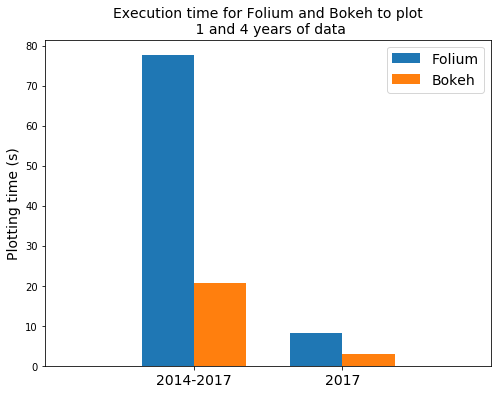

In [24]:
fig, ax = plt.subplots(figsize=(8,6))

width = 0.35
labels = ['2014-2017', '2017']
multi = [77.6, 8.13]
one = [20.8, 2.90]

ax.bar(np.arange(2) - width/2, multi, width, label='Folium')
ax.bar(np.arange(2) + width/2, one, width, label='Bokeh')

ax.set_ylabel('Plotting time (s)', fontsize=14)
ax.set_title('Execution time for Folium and Bokeh to plot\n 1 and 4 years of data', fontsize=14)
ax.set_xticks(np.arange(2))
ax.set_xticklabels(labels, fontsize=14)
ax.set_xlim(-1,2)

ax.legend(fontsize=14)
plt.savefig('times.png')

<img src="times.png">

## Thanks! Q&A time

## Aggregate by year

In [ ]:
df = pd.read_csv("WA_Rural_St_RtesCrashes_Full.csv")
df['date'] = pd.to_datetime(df['DATE'])

In [ ]:
df['year'] = df['date'].dt.year
df.groupby(['year']).agg(['count'])

### Num of cases across years

In [ ]:
df['year'].value_counts()

In [ ]:
from matplotlib import pyplot as plt
plt.plot(df['year'].value_counts().sort_index())
plt.show()